<a href="https://colab.research.google.com/github/mengusabah/ENS491-492-MAML/blob/main/maml_nn_mean_var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openpyxl

In [ ]:
# import libraries and read data from excel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
df = pd.read_excel("data_agg_new.xlsx")

ModuleNotFoundError: No module named 'keras'

In [ ]:
# make our data frame a python dictionary by grouping by PEVQS
df_dict = dict(tuple(df.groupby("PEVQS_INITIAL_BUFFERING_DELAY")))

# eliminating all the features but RSRP
for k,v in df_dict.items():
  df_dict[k] = v["RSRP_PCELL_1"]

# there are sessions with too less datapoints such as 4 datapoint etc
# eliminated such sessions
for k,v in df_dict.copy().items():
  if v.shape[0] < 50:
    del df_dict[k]

# make sure that every session has same size
for k,v in df_dict.items():
  df_dict[k] = df_dict[k].iloc[:50]

In [ ]:
mse_list_train = []
mape_list_train = []
mse_list_test = []
mape_list_test = []

for start_point in range(2,48):
  #start_point = int(input("When do you want to start forecasting: "))
  print("Current start point:", start_point)
  datasetList = []
  trainPredictPlotList = []
  testPredictPlotList = []
  mse_list_inner_train = []
  mape_list_inner_train = []
  mse_list_inner_test = []
  mape_list_inner_test = []

  for session_no in range(len(list(df_dict.values()))):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(list(df_dict.values())[session_no].values.reshape(-1,1))

    model = Sequential()
    model.add(LSTM(1, input_shape=(1, 1)))
    if session_no != 0:
      model.layers[0].set_weights(last_weight)
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(dataset[0:start_point-1], dataset[1:start_point], epochs=100, batch_size=1, verbose=0)
    print("Session {0} is done.".format(session_no))

    # getting latest weight of the previous model
    last_weight = model.layers[-2].get_weights()

    # make predictions
    trainPredict = model.predict(dataset[0:start_point-1])
    testPredict = model.predict(dataset[start_point:-2])

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(dataset[1:start_point])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(dataset[start_point+1:-1])

    # calculate mean squared error
    trainScore_MSE = mean_squared_error(trainY[:,0], trainPredict[:,0])
    print("Session {0} Train Score: {1} MSE".format(session_no, trainScore_MSE))
    mse_list_inner_train.append(trainScore_MSE)

    testScore_MSE = mean_squared_error(testY[:,0], testPredict[:,0])
    print("Session {0} Test Score: {1} MSE".format(session_no, testScore_MSE))
    mse_list_inner_test.append(testScore_MSE)


    # calculate mean absolute percentage error
    trainScore_MAPE = mean_absolute_percentage_error(trainY[:,0], trainPredict[:,0])
    print("Session {0} Train Score: {1} MAPE".format(session_no, trainScore_MAPE))
    mape_list_inner_train.append(trainScore_MAPE)
    mape_list_train.append(mape_list_inner_train)
    testScore_MAPE = mean_absolute_percentage_error(testY[:,0], testPredict[:,0])
    print("Session {0} Test Score: {1} MAPE\n".format(session_no, testScore_MAPE))
    mape_list_inner_test.append(testScore_MAPE)
    mape_list_test.append(mape_list_inner_test)

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(1*2):len(dataset)-1, :] = testPredict

    # storing plots
    datasetList.append(scaler.inverse_transform(dataset))
    trainPredictPlotList.append(trainPredictPlot)
    testPredictPlotList.append(testPredictPlot)
  mse_list_train.append(mse_list_inner_train)
  mse_list_test.append(mse_list_inner_test)
  mape_list_train.append(mape_list_inner_train)
  mape_list_test.append(mape_list_inner_test)

Current start point: 2
Session 0 is done.
2/2 [==============================] - 0s 0s/step
Session 0 Train Score: 82.65993803949095 MSE
Session 0 Test Score: 66.75197640439981 MSE
Session 0 Train Score: 0.0977607645014281 MAPE
Session 0 Test Score: 0.07838388781475149 MAPE

Session 1 is done.
2/2 [==============================] - 0s 3ms/step
Session 1 Train Score: 10.686891341174487 MSE
Session 1 Test Score: 205.86137425355645 MSE
Session 1 Train Score: 0.037575645008306395 MAPE
Session 1 Test Score: 0.17680565603347392 MAPE

Session 2 is done.
2/2 [==============================] - 0s 0s/step
Session 2 Train Score: 1.1347177720163018 MSE
Session 2 Test Score: 13.872357792014771 MSE
Session 2 Train Score: 0.012244038198186064 MAPE
Session 2 Test Score: 0.037773627982363264 MAPE

Session 3 is done.
2/2 [==============================] - 0s 2ms/step
Session 3 Train Score: 0.0005611815140589354 MSE
Session 3 Test Score: 79.77967944409339 MSE
Session 3 Train Score: 0.00023928555575298443

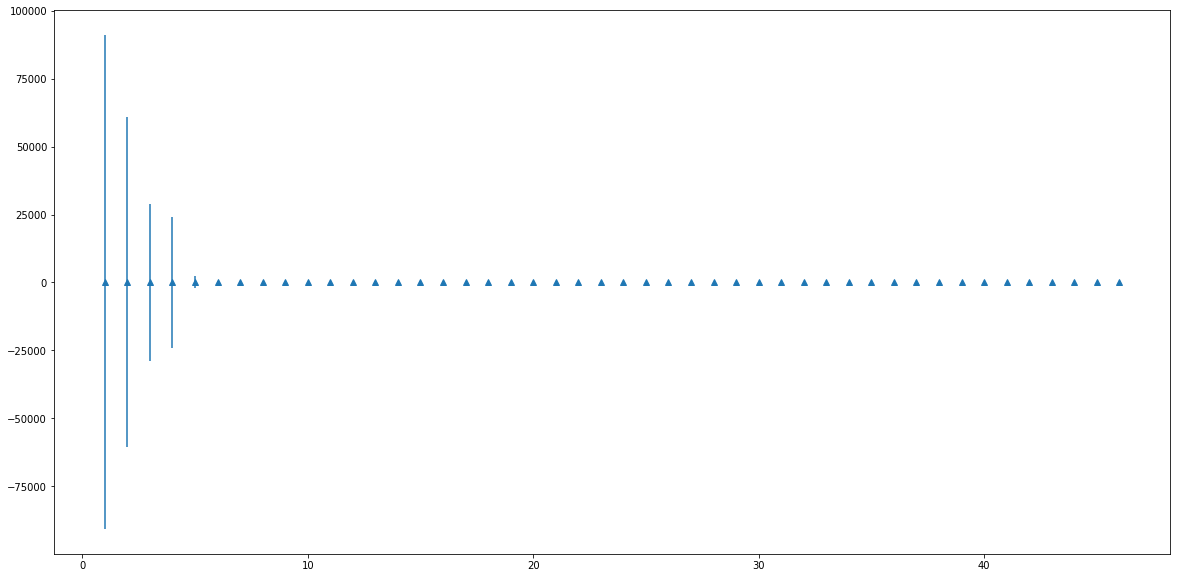

In [ ]:
mse_means_train = np.mean(np.array(mse_list_train), axis = 1)
mse_var_train = np.var(np.array(mse_list_train), axis = 1)
fig, ax = plt.subplots(figsize = (20,10))
ax.errorbar(list(range(1, 47)), mse_means_train, mse_var_train, linestyle="None", marker="^")
plt.show()

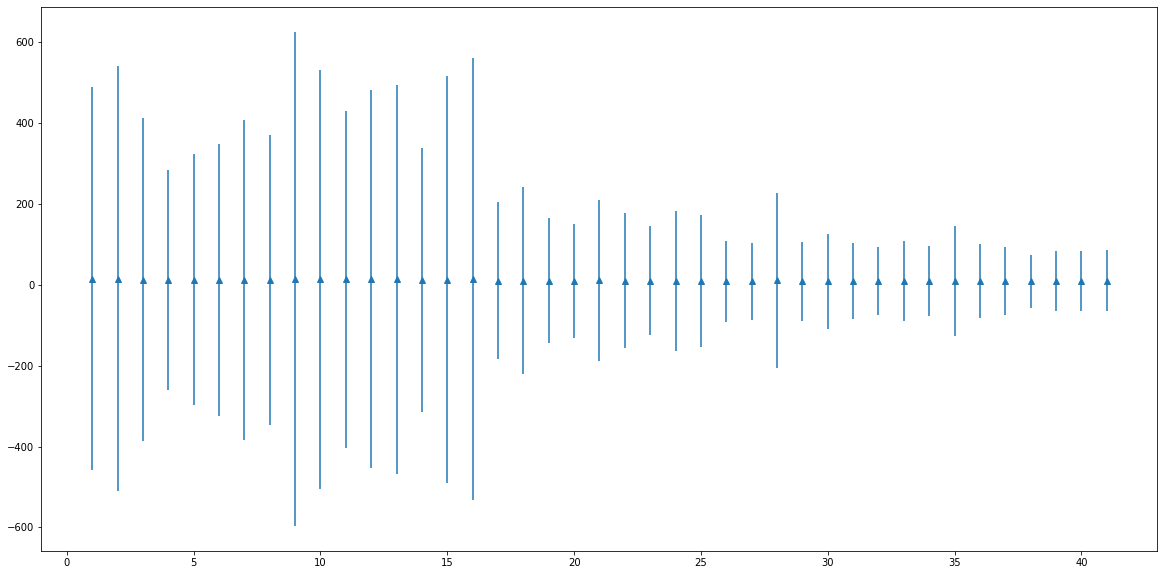

In [ ]:
mse_means_train = np.mean(np.array(mse_list_train), axis = 1)
mse_var_train = np.var(np.array(mse_list_train), axis = 1)
fig, ax = plt.subplots(figsize = (20,10))
ax.errorbar(list(range(1, 42)), mse_means_train[5:], mse_var_train[5:], linestyle="None", marker="^")
plt.show()

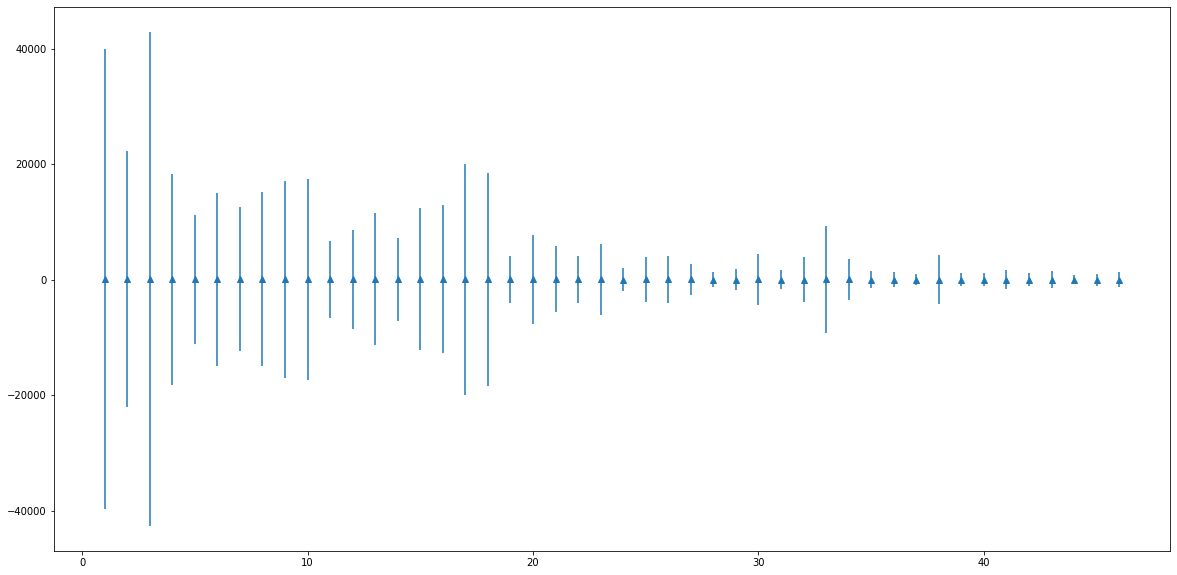

In [ ]:
mse_means_test = np.mean(np.array(mse_list_test), axis = 1)
mse_var_test = np.var(np.array(mse_list_test), axis = 1)
fig, ax = plt.subplots(figsize = (20,10))
plt.errorbar(list(range(1, 47)), mse_means_test, mse_var_test, linestyle="None", marker="^")
plt.show()

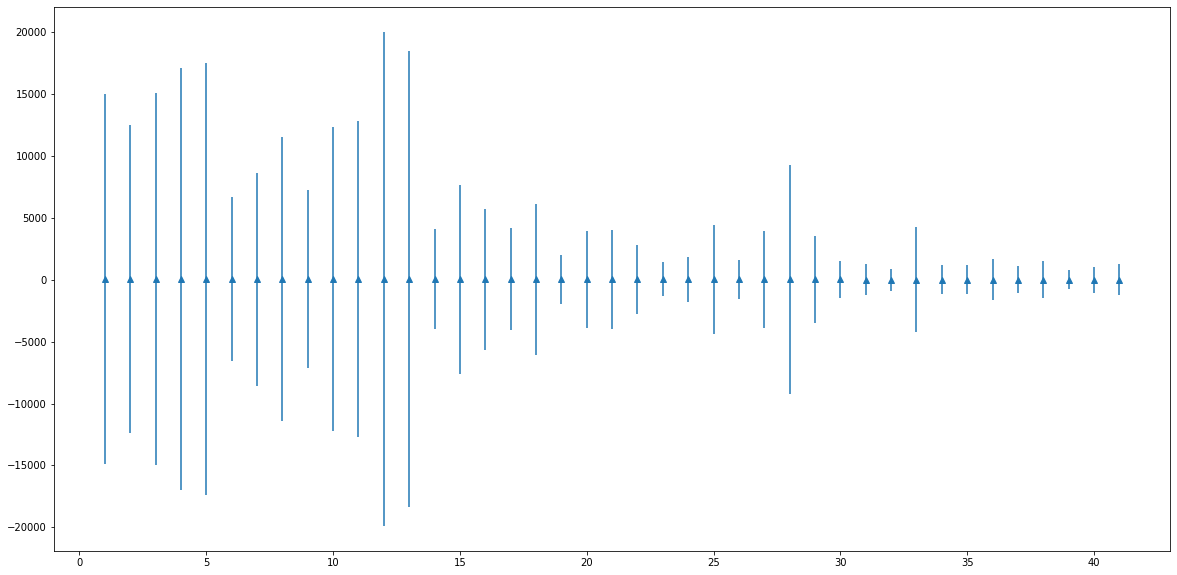

In [ ]:
mse_means_test = np.mean(np.array(mse_list_test), axis = 1)
mse_var_test = np.var(np.array(mse_list_test), axis = 1)
fig, ax = plt.subplots(figsize = (20,10))
plt.errorbar(list(range(1, 42)), mse_means_test[5:], mse_var_test[5:], linestyle="None", marker="^")
plt.show()